# Meta-Embedded Clustering (MEC)

In [1]:
# Import the librairies
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path

import umap
from hdbscan.validity import validity_index
from hdbscan import HDBSCAN, all_points_membership_vectors

import torch
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18, VGG16_Weights, vgg16, DenseNet121_Weights, densenet121, AlexNet_Weights, alexnet
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from kneed import KneeLocator

from darksound.dataset import Darksound
from darksound.config import load_config

from darksound.networks.protonet import PrototypicalNetworks
from darksound.networks.matchnet import MatchingNetworks
from darksound.networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Relation(torch.nn.Module):
    def __init__(self, backbone):
        super(Relation, self).__init__()
        self.backbone = backbone
        self.additional_layers = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d((1, 1)),torch.nn.Flatten())
    def forward(self, x):
        x = self.backbone(x)
        embedding = list(x.values())[0]
        x = self.additional_layers(embedding)
        return x

def get_features(model, spectrogram, device, params):
    # Extract the features from the model
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        relation_features = Relation(model.backbone).to(device)
        features = relation_features(spectrogram.to(device).unsqueeze(dim=0))
    else:
        features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach and convert to numpy array 
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, clusterer):
    # Remove noisy samples indexes from pseudo and true labels
    pseudo_labels = clusterer.labels_
    clustered = pseudo_labels >= 0
    # Compute evaluation metrics
    ari = adjusted_rand_score(true_labels[clustered], pseudo_labels[clustered])
    ami = adjusted_mutual_info_score(true_labels[clustered], pseudo_labels[clustered])
    # sometimes the validity index can't be computed
    try :
        dbcv, dbcv_per_cluster = validity_index(
                                    X=features.astype(np.float64),
                                    labels=pseudo_labels,
                                    metric='euclidean',
                                    per_cluster_scores=True)
    except:
        dbcv = np.nan  
        dbcv_per_cluster = [np.nan]
    return ari, ami, dbcv, dbcv_per_cluster 

def get_clusterer(features, n_components, method_reduc='PCA', method_cluster='DBSCAN', random_seed = 1979) :
    if method_reduc == 'PCA':
        # Linear reduction of dimensionality of the latent space 
        pca = PCA(n_components=n_components, random_state=random_seed)
        embedding = pca.fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'TSVD':  
        # Linear reduction of dimensionality of the latent space
        embedding = TruncatedSVD(n_components=n_components, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'UMAP':
        # Nonlinear reduction of dimensionality of the latent space
        embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    else:
        embedding = features
        k = n_components * 2 -1

    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding, n_neighbors=k)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    if method_cluster == 'HDBSCAN':
        # Perform HDBSCAN clustering from embedding array (min_cluster_size is equivalent to min_samples in DBSCAN)
        if eps == 0 :
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2).fit(embedding)
        else:
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2, cluster_selection_epsilon=eps).fit(embedding)
    elif method_cluster == 'DBSCAN':
        # Perform DBSCAN clustering from embedding array
        clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)

    return clusterer, embedding

## Import config file

In [3]:
# path to the parent folder
parent_path = "..//darksound"

# Import config file and load parameters
params = load_config(f'{parent_path}//config.yaml')

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)

bambird.extract_rois_full_sig


## Load the Darksound dataset

In [4]:
# Load the Darksound dataset
test_set = Darksound(split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=None,
                    n_classes=30,
                    download=True,
                    )
# Get the ground truth labels
true_labels = np.array(test_set.__getlabel__())


The config file /media/haupert/data/mes_projets/15_darksound/darksound.git/notebooks/config.yaml could not be loaded. Default parameters are loaded
Files already downloaded and verified


## Clusters examination

For each cluster, compute the species distribution, find the main species.

For each species, find how many samples are kept, in how many clusters

In [208]:
#--------------------------------------------------------------------------
# PREPARE THE DATA FOR THE CLUSTERING
#--------------------------------------------------------------------------
features = np.load(f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy')
n_components = 10
method_reduc = 'UMAP'
method_cluster = 'HDBSCAN'

# find the clusters
clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components=n_components, 
                                method_reduc=method_reduc, 
                                method_cluster=method_cluster,
                                random_seed=random_seed)

# Get the predicted labels and the number of clusters
pseudo_labels = clusterer.labels_ 
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

# Compute evaluation metrics
ari, ami, dbcv, per_cluster_dbcv = evaluation(embedding, true_labels, clusterer)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')


Clustering 77% of the data: Found 40 clusters with n_components=10.
ARI: 0.6520746490429019
AMI: 0.7955142191129173
DBCV: 0.2660427827630831
DBCVavg: 0.3964917704730815



In [209]:
# Get the list of tuples (file, label) for each species
species_files = test_set._flat_species_files
# Get the list of species
species = test_set._species
# Create a dictionary with the label as keys and the species as values
species_dict = {label: species for label, species in zip(np.unique(true_labels), species)}

species_dict

{0: 'Chordeiles acutipennis_Lesser Nighthawk',
 1: 'Crypturellus soui_Little Tinamou',
 2: 'Nyctibius leucopterus_White-winged Potoo',
 3: 'Nyctibius griseus_Common Potoo',
 4: 'Strix huhula_Black-banded Owl',
 5: 'Hydropsalis cayennensis_White-tailed Nightjar',
 6: 'Hydropsalis climacocerca_Ladder-tailed Nightjar',
 7: 'Nyctiprogne leucopyga_Band-tailed Nighthawk',
 8: 'Lurocalis semitorquatus_Short-tailed Nighthawk',
 9: 'Chordeiles nacunda_Nacunda Nighthawk',
 10: 'Megascops watsonii_Tawny-bellied Screech Owl',
 11: 'Glaucidium hardyi_Amazonian Pygmy Owl',
 12: 'Lophostrix cristata_Crested Owl',
 13: 'Nyctipolus nigrescens_Blackish Nightjar',
 14: 'Micrastur semitorquatus_Collared Forest Falcon',
 15: 'Crypturellus variegatus_Variegated Tinamou',
 16: 'Crypturellus brevirostris_Rusty Tinamou',
 17: 'Tinamus major_Great Tinamou',
 18: 'Micrastur gilvicollis_Lined Forest Falcon',
 19: 'Megascops roraimae_Foothill Screech Owl',
 20: 'Nyctidromus albicollis_Pauraque',
 21: 'Pulsatrix pe

In [210]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Crypturellus soui_Little Tinamou : 1
    Nyctibius griseus_Common Potoo : 1
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Glaucidium hardyi_Amazonian Pygmy Owl : 1
    Nyctipolus nigrescens_Blackish Nightjar : 31
    Nyctidromus albicollis_Pauraque : 588
    Nyctibius grandis_Great Potoo : 4
Cluster 1 :
    Hydropsalis climacocerca_Ladder-tailed Nightjar : 21
Cluster 2 :
    Hydropsalis cayennensis_White-tailed Nightjar : 20
Cluster 3 :
    Hydropsalis cayennensis_White-tailed Nightjar : 18
    Hydropsalis maculicaudus_Spot-tailed Nightjar : 339
Cluster 4 :
    Hydropsalis cayennensis_White-tailed Nightjar : 33
Cluster 5 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Micrastur gilvicollis_Lined Forest Falcon : 1
    Micrastur ruficollis_Barred Forest Falcon : 43
Cluster 6 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Nyctipolus nigrescens_Blackish Nightjar : 51
Cluster 7 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 138
    Lurocal

In [211]:
# Find the label in true_labels that are not present in pseudo_labels
missing_species_any_cluster = np.setdiff1d(true_labels, pseudo_labels)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')


0 / 30 species are not present in any cluster.
The list is:


In [212]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Nyctidromus albicollis_Pauraque : 94%
Cluster 1 : Hydropsalis climacocerca_Ladder-tailed Nightjar : 100%
Cluster 2 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 3 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 95%
Cluster 4 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 5 : Micrastur ruficollis_Barred Forest Falcon : 96%
Cluster 6 : Nyctipolus nigrescens_Blackish Nightjar : 98%
Cluster 7 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 97%
Cluster 8 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 92%
Cluster 9 : Lurocalis semitorquatus_Short-tailed Nighthawk : 97%
Cluster 10 : Lurocalis semitorquatus_Short-tailed Nighthawk : 96%
Cluster 11 : Pulsatrix perspicillata_Spectacled Owl : 89%
Cluster 12 : Lophostrix cristata_Crested Owl : 85%
Cluster 13 : Strix huhula_Black-banded Owl : 100%
Cluster 14 : Strix huhula_Black-banded Owl : 81%
Cluster 15 : Crypturellus cinereus_Cinereous Tinamou : 61%
Cluster 16 : Strix virgata_Mottled Owl : 89%
Clus

In [213]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

9 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Crypturellus soui_Little Tinamou
    Nyctibius leucopterus_White-winged Potoo
    Chordeiles nacunda_Nacunda Nighthawk
    Glaucidium hardyi_Amazonian Pygmy Owl
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Nyctibius bracteatus_Rufous Potoo


## Multiple UMAP

The idea is to perform 
1. multiple UMAP reduction with different 
2. find the clusters from the vectors found after the UMAP reduction
3. create a matrix with n rows corresponding to the number of samples and m columns corresponding to the number of clustering

The goal is to have a better estimation of the samples that are similar (always in the same cluster)

Methods to group the samples
- pairwise distance then clustering on the distance (kmeans ?)
- find similar sequence of numbers (DNA...)
- find similar sequence of categories

In [214]:
#--------------------------------------------------------------------------
# PREPARE THE DATA FOR THE CLUSTERING
#--------------------------------------------------------------------------
features = np.load(f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy')
n_components = [5,10,15,20,25,30]
method_reduc = 'UMAP'
method_cluster = 'DBSCAN'

pseudo_labels_list = []

# find the clusters
for n_component in n_components :
    clusterer, embedding = get_clusterer(
                                    features=features, 
                                    n_components=n_component, 
                                    method_reduc=method_reduc, 
                                    method_cluster=method_cluster,
                                    random_seed=random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    # Compute evaluation metrics
    ari, ami, dbcv, per_cluster_dbcv = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')

    pseudo_labels_list += [pseudo_labels]


Clustering 65% of the data: Found 76 clusters with n_components=[5, 10, 15, 20, 25, 30].
ARI: 0.7250379486723059
AMI: 0.8116815540360092
DBCV: nan
DBCVavg: nan


Clustering 53% of the data: Found 36 clusters with n_components=[5, 10, 15, 20, 25, 30].
ARI: 0.8047130742089781
AMI: 0.861460614450447
DBCV: 0.07277189780071229
DBCVavg: 0.2865396020794036


Clustering 43% of the data: Found 24 clusters with n_components=[5, 10, 15, 20, 25, 30].
ARI: 0.8726345504313577
AMI: 0.904922151498595
DBCV: 0.2548730539234031
DBCVavg: 0.562179871799439


Clustering 37% of the data: Found 18 clusters with n_components=[5, 10, 15, 20, 25, 30].
ARI: 0.8872620281584215
AMI: 0.922493341629999
DBCV: 0.2633127769580753
DBCVavg: 0.6953401088371067


Clustering 30% of the data: Found 14 clusters with n_components=[5, 10, 15, 20, 25, 30].
ARI: 0.8932636702030655
AMI: 0.9376952829201781
DBCV: 0.24335240958677495
DBCVavg: 0.7683566514062737


Clustering 27% of the data: Found 13 clusters with n_components=[5, 10,

In [215]:
# Transposition of the list of pseudo_labels
sequence_cluster_ids = np.array(pseudo_labels_list).T

#### Sequence Graph Transform
Code the vector of clusters into a sequence of strings (alphabet)

Then we will try methods to clusters sequence of alphabet such as for proteins, DNA, NLP...

In [216]:
# transform integer (Cluster ID) into string such as 'C0'
sequence_cluster_ids_str = np.array([f'C{cluster_id}' if cluster_id != -1 else 'Noise' for cluster_id in sequence_cluster_ids.flatten()]).reshape(sequence_cluster_ids.shape)

# add an index as a new dimension at the beginning of the array
sequence_cluster_ids_str_with_index = np.array([[i+1, sequence_cluster_ids_str[i]] for i in range(sequence_cluster_ids_str.shape[0])])

# convert the array into a pandas DataFrame
df_sequence_cluster_ids = pd.DataFrame(sequence_cluster_ids_str_with_index, columns=['id', 'sequence'])
df_sequence_cluster_ids

,id,sequence
0,1,"[Noise, Noise, Noise, Noise, Noise, Noise]"
1,2,"[C0, C0, C0, C0, C4, Noise]"
2,3,"[C0, Noise, C0, C0, C4, Noise]"
3,4,"[C0, C0, C0, C0, C4, Noise]"
4,5,"[Noise, Noise, Noise, Noise, Noise, Noise]"
...,...,...
8158,8159,"[Noise, Noise, Noise, Noise, Noise, Noise]"
8159,8160,"[Noise, Noise, Noise, Noise, Noise, Noise]"
8160,8161,"[Noise, Noise, Noise, Noise, Noise, Noise]"
8161,8162,"[Noise, Noise, Noise, Noise, Noise, Noise]"


In [217]:
# https://github.com/cran2367/sgt/blob/master/sgt.ipynb
# Sequence Graph Transform (SGT) — Sequence Embedding for Clustering, Classification, and Search

from sgt import SGT
import pandarallel  # required library for multiprocessing

sgt = SGT(kappa=1, 
        flatten=True, 
        lengthsensitive=True,
        mode='multiprocessing')

sgtembedding_df = sgt.fit_transform(corpus=df_sequence_cluster_ids)

sgtembedding_df

INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,id,"(C0, C0)","(C0, C1)","(C0, C10)","(C0, C11)","(C0, C12)","(C0, C13)","(C0, C14)","(C0, C15)","(C0, C16)",...,"(Noise, C7)","(Noise, C70)","(Noise, C71)","(Noise, C72)","(Noise, C73)","(Noise, C74)","(Noise, C75)","(Noise, C8)","(Noise, C9)","(Noise, Noise)"
0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
1,2.0,1.424096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3.0,1.106004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109894
3,4.0,1.424096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,8159.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
8159,8160.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
8160,8161.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
8161,8162.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388


In [218]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(C0, C0)","(C0, C1)","(C0, C10)","(C0, C11)","(C0, C12)","(C0, C13)","(C0, C14)","(C0, C15)","(C0, C16)","(C0, C17)",...,"(Noise, C7)","(Noise, C70)","(Noise, C71)","(Noise, C72)","(Noise, C73)","(Noise, C74)","(Noise, C75)","(Noise, C8)","(Noise, C9)","(Noise, Noise)"
id,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
2.0,1.424096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3.0,1.106004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109894
4.0,1.424096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8159.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
8160.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388
8161.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.029388


In [219]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
pca.fit(sgtembedding_df)

X=pca.transform(sgtembedding_df)

print(np.sum(pca.explained_variance_ratio_))

# create a dataframe with the PCA components 
df = pd.DataFrame(data=X, columns=[f'PC{i+1}' for i in range(n_components)])

df.head()


0.2398685574280901


,PC1,PC2
0,-0.278147,-0.210985
1,-0.108441,0.065387
2,-0.129239,0.031242
3,-0.108441,0.065387
4,-0.278147,-0.210985


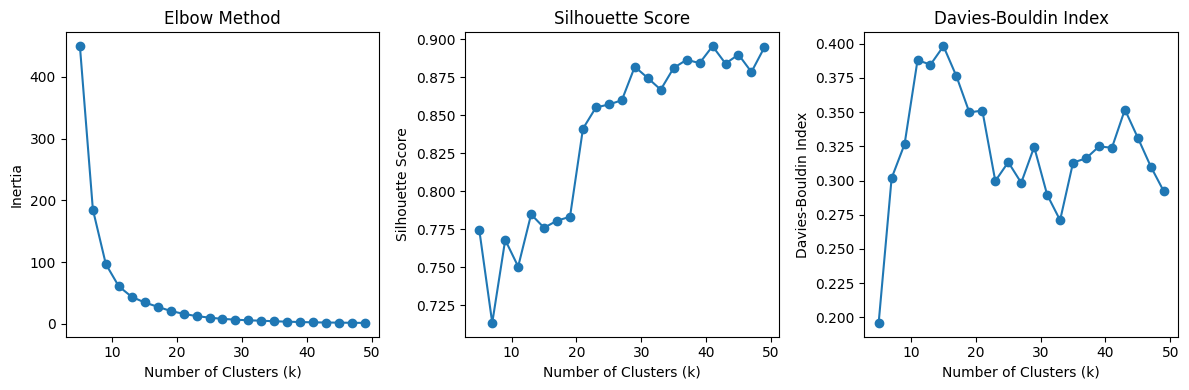

In [220]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from colorsys import hls_to_rgb
import matplotlib.cm as cm

# Define the range of k values
k_values = range(5, 50, 2)

# Initialize lists to store metric scores
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []

# Iterate over each value of k
for k in k_values:
    # Initialize and fit KMeans model
    kmeans = KMeans(n_clusters=k, max_iter=300)
    kmeans.fit(df)
    
    # Calculate inertia, silhouette score, and Davies-Bouldin index
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette score
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

# Plot Davies-Bouldin index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

plt.tight_layout()
plt.show()


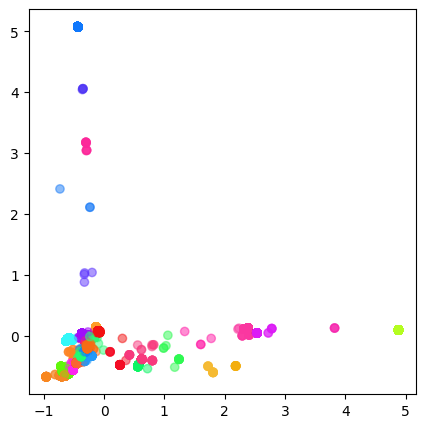

In [228]:
BEST_K = 32

clustering = KMeans(n_clusters=BEST_K, max_iter=300)
clustering.fit(df)
labels = clustering.predict(df)
centroids = clustering.cluster_centers_

fig = plt.figure(figsize=(5, 5))


# create a dictionnary with the color map matching a label and a color within a for loop
colmap = {i: hls_to_rgb(
                np.random.rand(), 
                (50 + np.random.rand() * 10) / 100., 
                (90 + np.random.rand() * 10) / 100.) for i in range(BEST_K+1)}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['PC1'], df['PC2'], color=colors, alpha=0.5, edgecolor=colors)

In [248]:
# Get the predicted labels and the number of clusters
pseudo_labels = labels
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} ')

# Compute evaluation metrics
ari, ami, dbcv, per_cluster_dbcv = evaluation(pseudo_labels, true_labels, clustering)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')



Clustering 100% of the data: Found 32 
ARI: 0.11420102185876144
AMI: 0.40672554666921196
DBCV: -0.7559788900300997
DBCVavg: -0.6169215828029224



In [249]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Chordeiles acutipennis_Lesser Nighthawk : 14
    Crypturellus soui_Little Tinamou : 239
    Nyctibius leucopterus_White-winged Potoo : 33
    Nyctibius griseus_Common Potoo : 156
    Strix huhula_Black-banded Owl : 119
    Hydropsalis cayennensis_White-tailed Nightjar : 35
    Hydropsalis climacocerca_Ladder-tailed Nightjar : 58
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 45
    Lurocalis semitorquatus_Short-tailed Nighthawk : 75
    Chordeiles nacunda_Nacunda Nighthawk : 2
    Megascops watsonii_Tawny-bellied Screech Owl : 63
    Glaucidium hardyi_Amazonian Pygmy Owl : 104
    Lophostrix cristata_Crested Owl : 22
    Nyctipolus nigrescens_Blackish Nightjar : 61
    Micrastur semitorquatus_Collared Forest Falcon : 171
    Crypturellus variegatus_Variegated Tinamou : 56
    Crypturellus brevirostris_Rusty Tinamou : 22
    Tinamus major_Great Tinamou : 99
    Micrastur gilvicollis_Lined Forest Falcon : 274
    Megascops roraimae_Foothill Screech Owl : 63
    Nyctidr

In [250]:
# Find the label in true_labels that are not present in pseudo_labels
missing_species_any_cluster = np.setdiff1d(true_labels, pseudo_labels)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')


0 / 30 species are not present in any cluster.
The list is:


In [251]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Micrastur ruficollis_Barred Forest Falcon : 16%
Cluster 1 : Lophostrix cristata_Crested Owl : 99%
Cluster 2 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 100%
Cluster 3 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 87%
Cluster 4 : Glaucidium hardyi_Amazonian Pygmy Owl : 62%
Cluster 5 : Micrastur ruficollis_Barred Forest Falcon : 44%
Cluster 6 : Crypturellus cinereus_Cinereous Tinamou : 62%
Cluster 7 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 100%
Cluster 8 : Nyctidromus albicollis_Pauraque : 100%
Cluster 9 : Nyctidromus albicollis_Pauraque : 100%
Cluster 10 : Pulsatrix perspicillata_Spectacled Owl : 93%
Cluster 11 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 38%
Cluster 12 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 100%
Cluster 13 : Micrastur ruficollis_Barred Forest Falcon : 26%
Cluster 14 : Micrastur gilvicollis_Lined Forest Falcon : 22%
Cluster 15 : Nyctidromus albicollis_Pauraque : 100%
Cluster 16 : Glaucidium hardyi_Amazonian Pygmy Owl : 48%
Clus

In [252]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

14 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Nyctibius leucopterus_White-winged Potoo
    Nyctibius griseus_Common Potoo
    Strix huhula_Black-banded Owl
    Hydropsalis cayennensis_White-tailed Nightjar
    Hydropsalis climacocerca_Ladder-tailed Nightjar
    Chordeiles nacunda_Nacunda Nighthawk
    Megascops watsonii_Tawny-bellied Screech Owl
    Nyctipolus nigrescens_Blackish Nightjar
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Micrastur mirandollei_Slaty-backed Forest Falcon
    Nyctibius bracteatus_Rufous Potoo


#### Similary matrix (string distance metric) and similarity clustering

Spectral Clustering or Agglomerative Clustering

In [253]:
# Function to compute pairwise Jaccard similarities between samples
def jaccard_similarity_matrix(cluster_ids):
    # Compute intersection between pairs of samples
    intersection = np.dot(cluster_ids, cluster_ids.T)

    # Compute union between pairs of samples
    union = np.sum(cluster_ids[:, None, :] | cluster_ids[None, :, :], axis=2)

    # Compute Jaccard similarities
    jaccard_similarities = intersection / union.astype(float)
    np.fill_diagonal(jaccard_similarities, 1.0)  # Set diagonal to 1 (samples are identical to themselves)
    return jaccard_similarities

# Compute pairwise Jaccard similarities between samples
pairwise_similarities = jaccard_similarity_matrix(sequence_cluster_ids)
print(pairwise_similarities)

[[ 1.          0.5         0.33333333 ... -1.         -1.
  -1.        ]
 [ 0.5         1.          8.5        ...  0.5         0.5
   0.5       ]
 [ 0.33333333  8.5         1.         ...  0.33333333  0.33333333
   0.33333333]
 ...
 [-1.          0.5         0.33333333 ...  1.         -1.
  -1.        ]
 [-1.          0.5         0.33333333 ... -1.          1.
  -1.        ]
 [-1.          0.5         0.33333333 ... -1.         -1.
   1.        ]]


In [268]:
from sklearn.cluster import AgglomerativeClustering

# Replace NaN by 0 in pairwise similarities
pairwise_similarities = np.nan_to_num(pairwise_similarities)

# Perform hierarchical clustering based on pairwise similarities
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0.25)
cluster_labels = clustering.fit_predict(1 - pairwise_similarities)

# Determine the optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(1 - pairwise_similarities, cluster_labels)
print("Average silhouette score:", silhouette_avg)

Average silhouette score: 0.0


In [269]:
# Get the predicted labels and the number of clusters
pseudo_labels = cluster_labels
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} ')

# Compute evaluation metrics
ari, ami, dbcv, per_cluster_dbcv = evaluation(pseudo_labels, true_labels, clustering)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')


Clustering 100% of the data: Found 3 
ARI: 0.002096378453570019
AMI: 0.025424819034292355
DBCV: -0.9125230140841253
DBCVavg: -0.6748231695593322



In [270]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Chordeiles acutipennis_Lesser Nighthawk : 23
    Crypturellus soui_Little Tinamou : 421
    Nyctibius leucopterus_White-winged Potoo : 64
    Nyctibius griseus_Common Potoo : 170
    Strix huhula_Black-banded Owl : 292
    Hydropsalis cayennensis_White-tailed Nightjar : 89
    Hydropsalis climacocerca_Ladder-tailed Nightjar : 58
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 234
    Lurocalis semitorquatus_Short-tailed Nighthawk : 283
    Chordeiles nacunda_Nacunda Nighthawk : 4
    Megascops watsonii_Tawny-bellied Screech Owl : 121
    Glaucidium hardyi_Amazonian Pygmy Owl : 300
    Lophostrix cristata_Crested Owl : 390
    Nyctipolus nigrescens_Blackish Nightjar : 117
    Micrastur semitorquatus_Collared Forest Falcon : 580
    Crypturellus variegatus_Variegated Tinamou : 130
    Crypturellus brevirostris_Rusty Tinamou : 41
    Tinamus major_Great Tinamou : 329
    Micrastur gilvicollis_Lined Forest Falcon : 605
    Megascops roraimae_Foothill Screech Owl : 113
   